## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# Model Persistence
import joblib
import os

## 2. Load Dataset

In [3]:
# Load data
df = pd.read_csv('../data/repositories.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (215029, 24)

First few rows:


,Name,Description,URL,Created At,Updated At,Homepage,Size,Stars,Forks,Issues,...,Has Issues,Has Projects,Has Downloads,Has Wiki,Has Pages,Has Discussions,Is Fork,Is Archived,Is Template,Default Branch
0,freeCodeCamp,freeCodeCamp.org's open-source codebase and cu...,https://github.com/freeCodeCamp/freeCodeCamp,2014-12-24T17:49:19Z,2023-09-21T11:32:33Z,http://contribute.freecodecamp.org/,387451,374074,33599,248,...,True,True,True,False,True,False,False,False,False,main
1,free-programming-books,:books: Freely available programming books,https://github.com/EbookFoundation/free-progra...,2013-10-11T06:50:37Z,2023-09-21T11:09:25Z,https://ebookfoundation.github.io/free-program...,17087,298393,57194,46,...,True,False,True,False,True,False,False,False,False,main
2,awesome,😎 Awesome lists about all kinds of interesting...,https://github.com/sindresorhus/awesome,2014-07-11T13:42:37Z,2023-09-21T11:18:22Z,NaN,1441,269997,26485,61,...,True,False,True,False,True,False,False,False,False,main
3,996.ICU,Repo for counting stars and contributing. Pres...,https://github.com/996icu/996.ICU,2019-03-26T07:31:14Z,2023-09-21T08:09:01Z,https://996.icu,187799,267901,21497,16712,...,False,False,True,False,False,False,False,True,False,master
4,coding-interview-university,A complete computer science study plan to beco...,https://github.com/jwasham/coding-interview-un...,2016-06-06T02:34:12Z,2023-09-21T10:54:48Z,NaN,20998,265161,69434,56,...,True,False,True,False,False,False,False,False,False,main


## 3. Data Preprocessing

### 3.1 Handle Missing Values

In [4]:
# Check missing values
print("Missing Values Before Preprocessing:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

Missing Values Before Preprocessing:
Name                    2
Description          8032
URL                     0
Created At              0
Updated At              0
Homepage           136639
Size                    0
Stars                   0
Forks                   0
Issues                  0
Watchers                0
Language            16076
License             53039
Topics                  0
Has Issues              0
Has Projects            0
Has Downloads           0
Has Wiki                0
Has Pages               0
Has Discussions         0
Is Fork                 0
Is Archived             0
Is Template             0
Default Branch          0
dtype: int64

Total missing: 213788


In [5]:
# Handle missing values
# Language: Fill with 'Unknown'
if 'Language' in df.columns:
    df['Language'] = df['Language'].fillna('Unknown')

# License: Fill with 'No License'
if 'License' in df.columns:
    df['License'] = df['License'].fillna('No License')

# For other columns, fill numeric with median, categorical with mode
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing Values After Preprocessing:")
print(df.isnull().sum().sum())


Missing Values After Preprocessing:
0


### 3.2 Remove Multicollinearity

**Issue:** Watchers ≈ Stars (correlation ≈ 0.99) causes perfect multicollinearity.  
**Solution:** Drop Watchers column.

In [6]:
# Drop Watchers column (redundant with Stars)
if 'Watchers' in df.columns:
    print("Dropping 'Watchers' column (multicollinearity with Stars)")
    df = df.drop('Watchers', axis=1)
    
print(f"\nDataset shape after dropping Watchers: {df.shape}")

Dropping 'Watchers' column (multicollinearity with Stars)

Dataset shape after dropping Watchers: (215029, 23)


### 3.3 Feature Selection for Modeling

In [7]:
# Select relevant features for modeling
# Target: Stars
# Features: Numerical + Top categorical features

# Define feature columns
numerical_features = ['Forks', 'Open Issues', 'Size']
categorical_features = ['Language', 'Has Wiki', 'Has Issues', 'Has Projects']

# Keep only relevant columns
columns_to_keep = ['Stars'] + numerical_features + categorical_features

# Filter columns that exist in dataframe
columns_to_keep = [col for col in columns_to_keep if col in df.columns]

df_model = df[columns_to_keep].copy()

print(f"Features for modeling: {df_model.columns.tolist()}")
print(f"Dataset shape: {df_model.shape}")

Features for modeling: ['Stars', 'Forks', 'Size', 'Language', 'Has Wiki', 'Has Issues', 'Has Projects']
Dataset shape: (215029, 7)


### 3.4 Handle Extreme Skewness

Apply log transformation to highly skewed numerical features.

In [8]:
# Log transform skewed numerical features (add 1 to avoid log(0))
for col in numerical_features:
    if col in df_model.columns:
        df_model[f'{col}_log'] = np.log1p(df_model[col])
        print(f"Created log-transformed feature: {col}_log")

# Also transform target variable
df_model['Stars_log'] = np.log1p(df_model['Stars'])

print(f"\nDataset shape after feature engineering: {df_model.shape}")

Created log-transformed feature: Forks_log
Created log-transformed feature: Size_log

Dataset shape after feature engineering: (215029, 10)


### 3.5 Encode Categorical Variables

In [9]:
# Encode categorical variables
label_encoders = {}

for col in categorical_features:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[f'{col}_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")

print(f"\nTotal label encoders saved: {len(label_encoders)}")

Encoded Language: 370 unique values
Encoded Has Wiki: 2 unique values
Encoded Has Issues: 2 unique values
Encoded Has Projects: 2 unique values

Total label encoders saved: 4


### 3.6 Prepare Features and Target

In [10]:
# Select final features for modeling
feature_columns = [col for col in df_model.columns if ('_log' in col or '_encoded' in col) and col != 'Stars_log']

X = df_model[feature_columns]
y = df_model['Stars_log']  # Use log-transformed target

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()}")

Feature matrix shape: (215029, 6)
Target vector shape: (215029,)

Features used: ['Forks_log', 'Size_log', 'Language_encoded', 'Has Wiki_encoded', 'Has Issues_encoded', 'Has Projects_encoded']


### 3.7 Train-Test Split

In [11]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Train/Test split: {X_train.shape[0]/len(X)*100:.1f}% / {X_test.shape[0]/len(X)*100:.1f}%")

Training set size: 172023 samples
Testing set size: 43006 samples
Train/Test split: 80.0% / 20.0%


### 3.8 Feature Scaling

In [12]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature scaling completed")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled testing set shape: {X_test_scaled.shape}")

Feature scaling completed
Scaled training set shape: (172023, 6)
Scaled testing set shape: (43006, 6)


## 4. Model Training and Evaluation

Train multiple models and compare performance.

In [13]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

print(f"Total models to train: {len(models)}")

Total models to train: 6


In [14]:
# Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Store results
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }
    
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")


Training Linear Regression...
Training R²: 0.5161
Testing R²: 0.5193
Testing RMSE: 0.6825
Testing MAE: 0.5342

Training Ridge Regression...
Training R²: 0.5161
Testing R²: 0.5193
Testing RMSE: 0.6825
Testing MAE: 0.5342

Training Lasso Regression...
Training R²: 0.4917
Testing R²: 0.4946
Testing RMSE: 0.6998
Testing MAE: 0.5468

Training Random Forest...
Training R²: 0.9367
Testing R²: 0.5583
Testing RMSE: 0.6542
Testing MAE: 0.4977

Training Gradient Boosting...
Training R²: 0.6111
Testing R²: 0.6108
Testing RMSE: 0.6141
Testing MAE: 0.4687

Training XGBoost...
Training R²: 0.6439
Testing R²: 0.6174
Testing RMSE: 0.6089
Testing MAE: 0.4625


## 5. Model Comparison

In [15]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results],
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results]
})

comparison_df = comparison_df.sort_values('Test R²', ascending=False)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)


MODEL COMPARISON RESULTS
            Model  Train R²  Test R²  Test RMSE  Test MAE
          XGBoost  0.643922 0.617365   0.608901  0.462515
Gradient Boosting  0.611083 0.610849   0.614064  0.468707
    Random Forest  0.936675 0.558303   0.654210  0.497735
 Ridge Regression  0.516067 0.519256   0.682514  0.534158
Linear Regression  0.516067 0.519256   0.682514  0.534158
 Lasso Regression  0.491713 0.494580   0.699811  0.546756



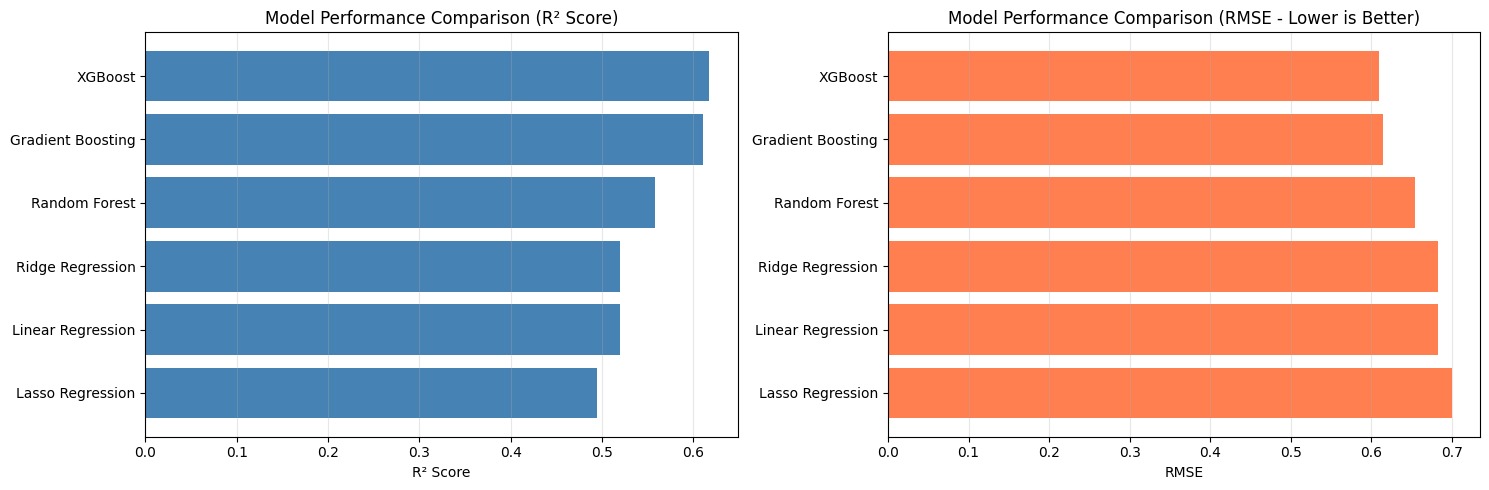

In [16]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
comparison_df_sorted = comparison_df.sort_values('Test R²')
axes[0].barh(comparison_df_sorted['Model'], comparison_df_sorted['Test R²'], color='steelblue')
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Performance Comparison (R² Score)')
axes[0].grid(axis='x', alpha=0.3)

# RMSE comparison
comparison_df_sorted_rmse = comparison_df.sort_values('Test RMSE', ascending=False)
axes[1].barh(comparison_df_sorted_rmse['Model'], comparison_df_sorted_rmse['Test RMSE'], color='coral')
axes[1].set_xlabel('RMSE')
axes[1].set_title('Model Performance Comparison (RMSE - Lower is Better)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Select Best Model

In [17]:
# Select best model based on Test R²
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"\nPerformance Metrics:")
print(f"  • Training R²: {results[best_model_name]['train_r2']:.4f}")
print(f"  • Testing R²: {results[best_model_name]['test_r2']:.4f}")
print(f"  • Testing RMSE: {results[best_model_name]['test_rmse']:.4f}")
print(f"  • Testing MAE: {results[best_model_name]['test_mae']:.4f}")


🏆 BEST MODEL: XGBoost

Performance Metrics:
  • Training R²: 0.6439
  • Testing R²: 0.6174
  • Testing RMSE: 0.6089
  • Testing MAE: 0.4625


## 7. Feature Importance (for tree-based models)


Feature Importance:
             Feature  Importance
           Forks_log    0.777029
Has Projects_encoded    0.056484
    Language_encoded    0.052231
  Has Issues_encoded    0.051603
    Has Wiki_encoded    0.038362
            Size_log    0.024292


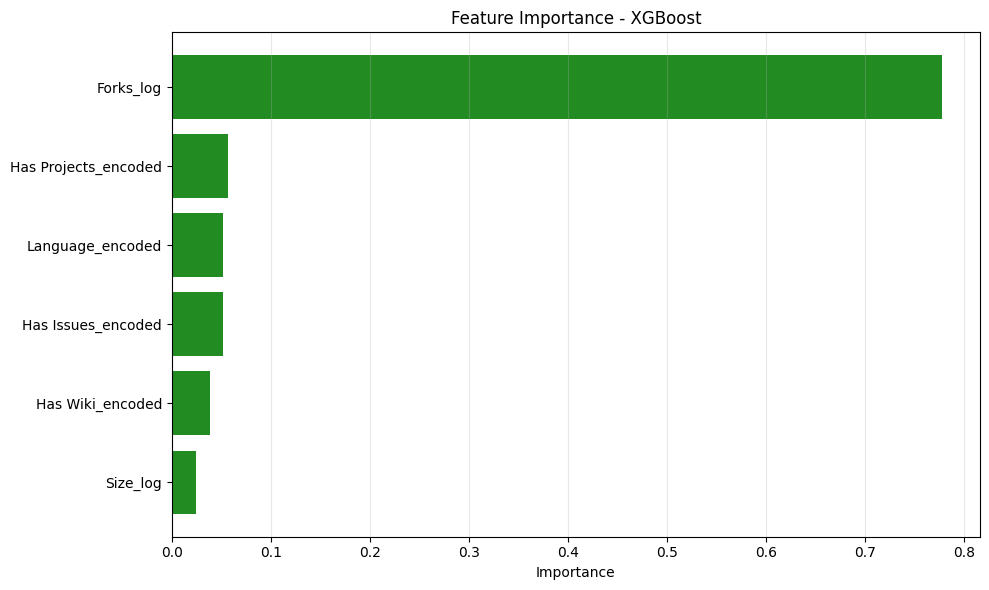

In [18]:
# Show feature importance if model supports it
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='forestgreen')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"\nNote: {best_model_name} does not support feature importance extraction.")

## 8. Prediction vs Actual Analysis

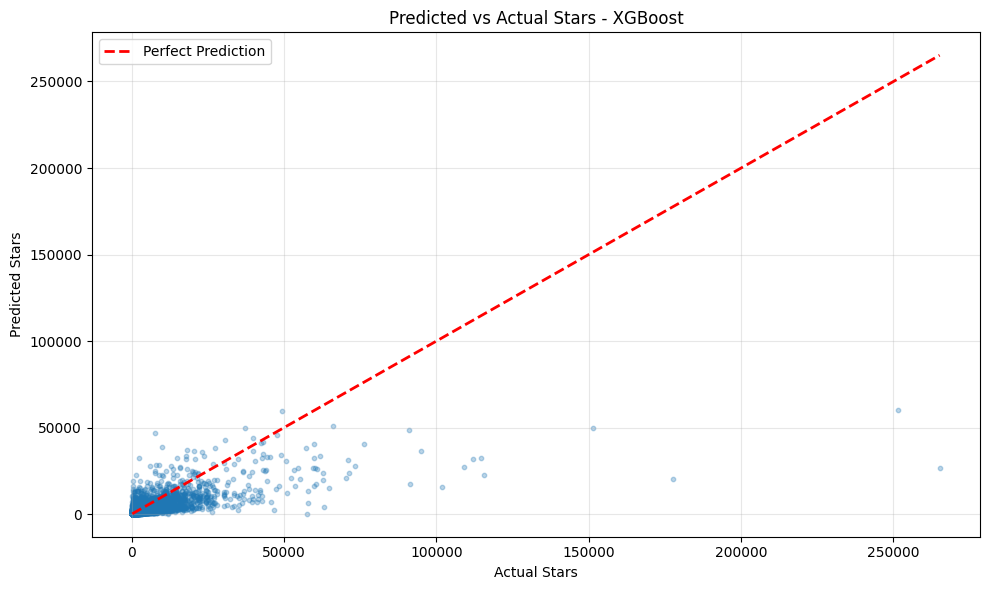

In [19]:
# Predictions on test set
y_pred_best = best_model.predict(X_test_scaled)

# Convert back from log scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_best)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.3, s=10)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Stars')
plt.ylabel('Predicted Stars')
plt.title(f'Predicted vs Actual Stars - {best_model_name}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save Models and Preprocessors

Save all necessary objects for deployment in Streamlit.

In [20]:
# Create models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save best model
joblib.dump(best_model, f'{models_dir}/best_model.pkl')
print(f"✅ Saved best model: {best_model_name}")

# Save scaler
joblib.dump(scaler, f'{models_dir}/scaler.pkl')
print(f"✅ Saved scaler")

# Save label encoders
joblib.dump(label_encoders, f'{models_dir}/label_encoders.pkl')
print(f"✅ Saved label encoders")

# Save feature columns
joblib.dump(feature_columns, f'{models_dir}/feature_columns.pkl')
print(f"✅ Saved feature columns")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'test_r2': results[best_model_name]['test_r2'],
    'test_rmse': results[best_model_name]['test_rmse'],
    'test_mae': results[best_model_name]['test_mae'],
    'training_samples': X_train.shape[0],
    'testing_samples': X_test.shape[0],
    'features': feature_columns
}
joblib.dump(metadata, f'{models_dir}/model_metadata.pkl')
print(f"✅ Saved model metadata")

# Save all models for comparison
for name, result in results.items():
    model_filename = name.lower().replace(' ', '_')
    joblib.dump(result['model'], f'{models_dir}/{model_filename}.pkl')
    print(f"✅ Saved {name}")

print(f"\n{'='*60}")
print(f"All models and preprocessors saved to '{models_dir}/'")
print(f"{'='*60}")

✅ Saved best model: XGBoost
✅ Saved scaler
✅ Saved label encoders
✅ Saved feature columns
✅ Saved model metadata
✅ Saved Linear Regression
✅ Saved Ridge Regression
✅ Saved Lasso Regression
✅ Saved Random Forest
✅ Saved Gradient Boosting
✅ Saved XGBoost

All models and preprocessors saved to '../models/'


## 10. Summary

### Data Preprocessing Steps Completed:
1. ✅ Handled missing values (Language, License)
2. ✅ Removed multicollinearity (dropped Watchers)
3. ✅ Log-transformed skewed features
4. ✅ Encoded categorical variables
5. ✅ Scaled numerical features
6. ✅ Split into train/test sets (80/20)

### Models Trained:
1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Random Forest
5. Gradient Boosting
6. XGBoost

### Next Steps:
- Deploy best model in Streamlit application
- Enable runtime predictions based on user input
- Visualize model performance interactively